# Homework Starter — Stage 10a: Linear Regression

Use this as a scaffold if your project data isn’t ready. Replace the synthetic data section with your dataset when possible.

In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
import scipy.stats as st

sns.set()
np.random.seed(7)

## 1) Synthetic data (replace with your project data when ready)
- Finance-flavored factors and asset excess return
- Includes a quadratic effect to motivate specification checks

In [ ]:
n = 200
dates = pd.bdate_range(start="2024-02-01", periods=n)
mkt_excess = np.random.normal(0, 0.011, size=n)
size = np.random.normal(0, 0.008, size=n)
value = np.random.normal(0, 0.009, size=n)
momentum = np.random.normal(0, 0.006, size=n)

beta0, beta_mkt, beta_size, beta_value, beta_mom, beta_mom2 = 0.0001, 0.9, 0.25, -0.15, 0.35, 3.5
noise_scale = 0.0035 + 0.5*np.abs(mkt_excess)
eps = np.random.normal(0, noise_scale)
asset_excess = (
    beta0 + beta_mkt*mkt_excess + beta_size*size + beta_value*value + beta_mom*momentum
    + beta_mom2*(momentum**2) + eps
)
df = pd.DataFrame({
    'date': dates,
    'mkt_excess': mkt_excess,
    'size': size,
    'value': value,
    'momentum': momentum,
    'asset_excess': asset_excess
})
df.head()

In [27]:
import yfinance as yf

# Load and prepare data
ticker = "SPY"
data = yf.download(ticker, start="2015-01-01", end="2023-12-31", progress=False)

# Create features and target
data['Returns'] = data['Close'].pct_change()
data['Volume_MA'] = data['Volume'].rolling(5).mean()
data['SMA_10'] = data['Close'].rolling(10).mean()
data['SMA_50'] = data['Close'].rolling(50).mean()

# Calculate RSI manually
def calculate_rsi(series, window=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window).mean()
    avg_loss = loss.rolling(window).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

data['RSI'] = calculate_rsi(data['Close'])

# Calculate MACD manually
def calculate_macd(series, fast=12, slow=26, signal=9):
    ema_fast = series.ewm(span=fast).mean()
    ema_slow = series.ewm(span=slow).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signal).mean()
    return macd_line - signal_line

data['MACD'] = calculate_macd(data['Close'])

# Clean data and prepare for modeling
clean_data = data[['Returns', 'Volume_MA', 'SMA_10', 'SMA_50', 'RSI', 'MACD']].dropna()
X = clean_data[['Volume_MA', 'SMA_10', 'SMA_50', 'RSI', 'MACD']]
y = clean_data['Returns']

print(f"Clean dataset shape: {clean_data.shape}")
print(f"Features: {list(X.columns)}")

Clean dataset shape: (2215, 6)
Features: [('Volume_MA', ''), ('SMA_10', ''), ('SMA_50', ''), ('RSI', ''), ('MACD', '')]


/var/folders/_4/t03mdfy94ts0ylt8cw0q1bp00000gn/T/ipykernel_19517/3623713259.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2023-12-31", progress=False)


## 2) Baseline model fit
Follow the steps; replace `df` with your project DataFrame when ready.

In [ ]:
X = df[['mkt_excess','size','value','momentum']]
y = df['asset_excess']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
lr = LinearRegression().fit(X_train, y_train)
y_pred = lr.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'Baseline   R²={r2:.4f}  RMSE={rmse:.6f}')

In [ ]:
resid = y_test - y_pred
fitted = y_pred
plt.figure(); plt.scatter(fitted, resid); plt.axhline(0, ls='--'); plt.title('Residuals vs Fitted'); plt.show()
plt.figure(); plt.hist(resid, bins=20); plt.title('Residual Histogram'); plt.show()
plt.figure(); st.probplot(resid, dist='norm', plot=plt); plt.title('QQ Plot'); plt.show()

In [32]:
# Split data chronologically (time-series aware)
split_idx = int(0.8 * len(X))
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"Train set: {X_train.shape}, Test set: {X_test.shape}")

# Fit linear regression
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Compute metrics
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.6f}")
print(f"Coefficients: {dict(zip(X.columns, model.coef_))}")

Train set: (1772, 5), Test set: (443, 5)
R² Score: 0.0586
RMSE: 0.011732
Coefficients: {('Volume_MA', ''): np.float64(1.8983246596779032e-11), ('SMA_10', ''): np.float64(-0.00010406452700209952), ('SMA_50', ''): np.float64(0.00010798590582473165), ('RSI', ''): np.float64(0.0001630134753187124), ('MACD', ''): np.float64(0.0009903514464129905)}


In [23]:
import scipy.stats as stats

# Calculate residuals
residuals = y_test - y_pred

# Residual analysis metrics
residual_mean = residuals.mean()
residual_std = residuals.std()
residual_skew = stats.skew(residuals)
residual_kurtosis = stats.kurtosis(residuals)

print(f"Residual Mean: {residual_mean:.6f} (should be ~0)")
print(f"Residual STD: {residual_std:.6f}")
print(f"Residual Skewness: {residual_skew:.4f}")
print(f"Residual Kurtosis: {residual_kurtosis:.4f}")

Residual Mean: 0.000177 (should be ~0)
Residual STD: 0.011785
Residual Skewness: 0.1250
Residual Kurtosis: 1.5057


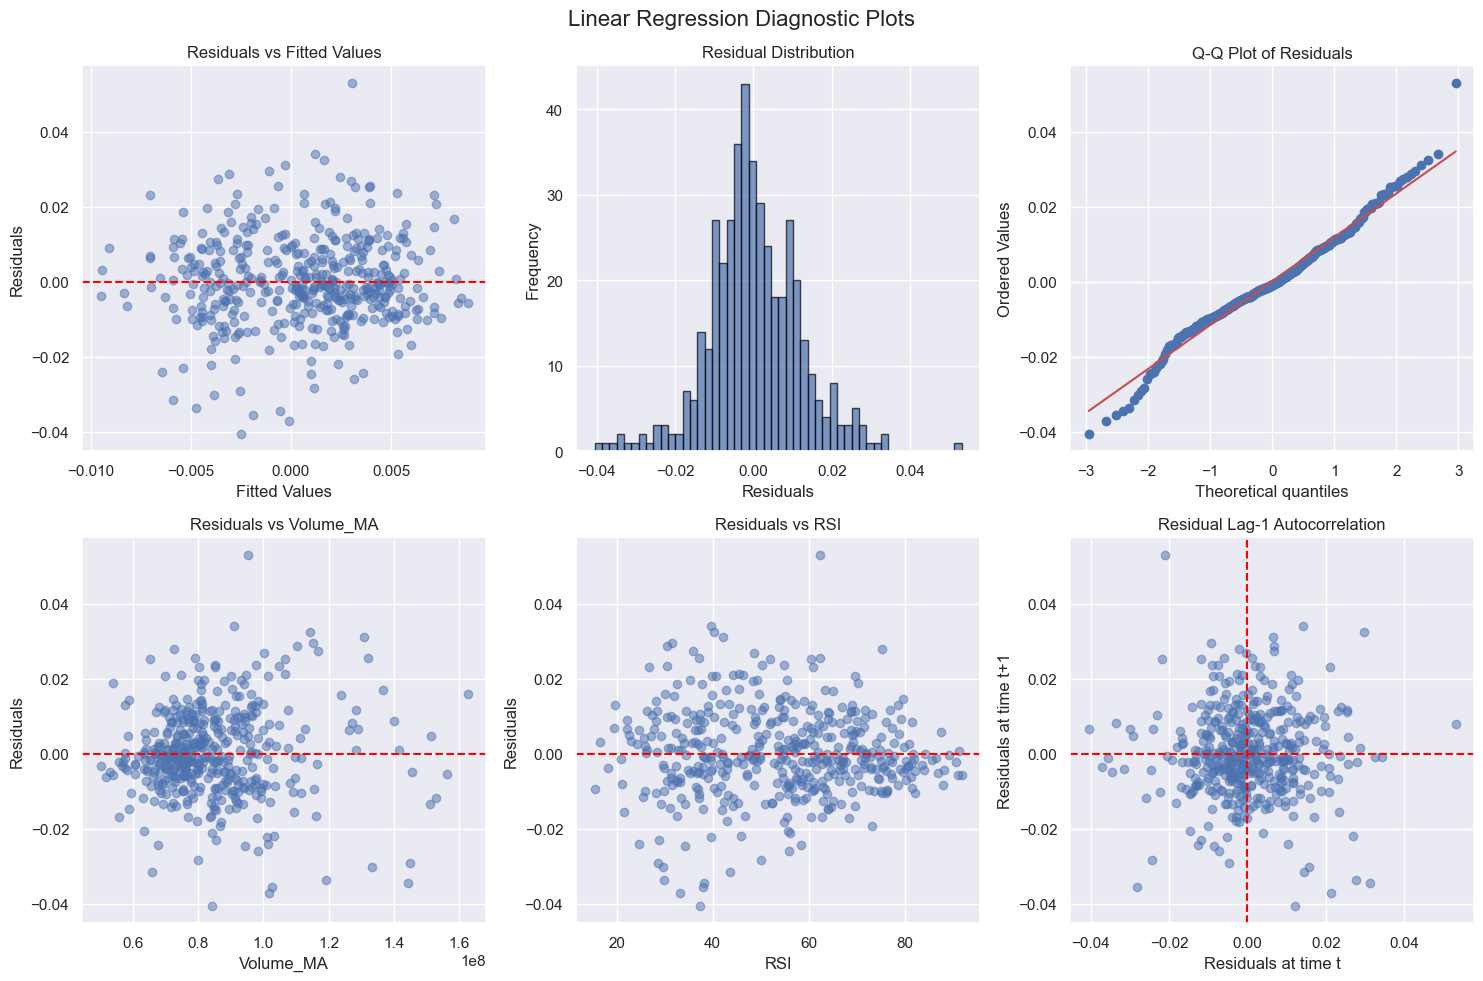

In [30]:
# Create diagnostic plots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Linear Regression Diagnostic Plots', fontsize=16)

# 1. Residuals vs Fitted Values
axes[0,0].scatter(y_pred, residuals, alpha=0.5)
axes[0,0].axhline(y=0, color='red', linestyle='--')
axes[0,0].set_xlabel('Fitted Values')
axes[0,0].set_ylabel('Residuals')
axes[0,0].set_title('Residuals vs Fitted Values')

# 2. Histogram of Residuals
axes[0,1].hist(residuals, bins=50, alpha=0.7, edgecolor='black')
axes[0,1].set_xlabel('Residuals')
axes[0,1].set_ylabel('Frequency')
axes[0,1].set_title('Residual Distribution')

# 3. Q-Q Plot
stats.probplot(residuals, dist="norm", plot=axes[0,2])
axes[0,2].set_title('Q-Q Plot of Residuals')

# 4. Residuals vs Volume_MA (key predictor)
axes[1,0].scatter(X_test['Volume_MA'], residuals, alpha=0.5)
axes[1,0].axhline(y=0, color='red', linestyle='--')
axes[1,0].set_xlabel('Volume_MA')
axes[1,0].set_ylabel('Residuals')
axes[1,0].set_title('Residuals vs Volume_MA')

# 5. Residuals vs RSI
axes[1,1].scatter(X_test['RSI'], residuals, alpha=0.5)
axes[1,1].axhline(y=0, color='red', linestyle='--')
axes[1,1].set_xlabel('RSI')
axes[1,1].set_ylabel('Residuals')
axes[1,1].set_title('Residuals vs RSI')

# 6. Lag-1 Residual Autocorrelation
axes[1,2].scatter(residuals[:-1], residuals[1:], alpha=0.5)
axes[1,2].axhline(y=0, color='red', linestyle='--')
axes[1,2].axvline(x=0, color='red', linestyle='--')
axes[1,2].set_xlabel('Residuals at time t')
axes[1,2].set_ylabel('Residuals at time t+1')
axes[1,2].set_title('Residual Lag-1 Autocorrelation')

plt.tight_layout()
plt.show()

## 3) Optional: Add a transformed feature
Add a polynomial or interaction if diagnostics suggest mis-specification.

In [ ]:
df['momentum_sq'] = df['momentum']**2
X2 = df[['mkt_excess','size','value','momentum','momentum_sq']]
X2_train, X2_test = X2.iloc[:len(X_train)], X2.iloc[len(X_train):]
lr2 = LinearRegression().fit(X2_train, y_train)
y_pred2 = lr2.predict(X2_test)
r2_2 = r2_score(y_test, y_pred2)
rmse_2 = mean_squared_error(y_test, y_pred2, squared=False)
print(f'With x^2   R²={r2_2:.4f}  RMSE={rmse_2:.6f}')

In [31]:
# Try squared RSI feature (capture non-linear effects)
X_transformed = X.copy()
X_transformed['RSI_Squared'] = X['RSI'] ** 2

# Split transformed data
X_train_trans, X_test_trans = X_transformed.iloc[:split_idx], X_transformed.iloc[split_idx:]

# Refit model
model_trans = LinearRegression()
model_trans.fit(X_train_trans, y_train)
y_pred_trans = model_trans.predict(X_test_trans)

# Compare performance
r2_trans = r2_score(y_test, y_pred_trans)
rmse_trans = np.sqrt(mean_squared_error(y_test, y_pred_trans))

print(f"Original R²: {r2:.4f}, Transformed R²: {r2_trans:.4f}")
print(f"Original RMSE: {rmse:.6f}, Transformed RMSE: {rmse_trans:.6f}")

Original R²: 0.0586, Transformed R²: 0.0530
Original RMSE: 0.011732, Transformed RMSE: 0.011767


## 4) Interpretation (write your conclusions below)
- Linearity: The residuals vs. fitted plot shows that the residual values should be randomly scattered around 0, meaning that the linearity condition is satisfied. 
- Homoscedasticity: Based on observing the residual values being randomly scattered around 0 from the residuals vs. fitted plot, we can also determine that the condition of homoscedasticity is satisfied. 
- Normality: The histogram visualizing the distribution of residuals shows that the distribution appears to be roughly symmetric, and the data points on the QQ plot appear to roughly follow a straight line, so the condition of normality is satisfied. 
- Independence: The data points in the residual lag-1 autocorrelation plot appear to be randomly scattered but with some minor clustering, there could be some potential time-series dependencies between predictors. 
- Which model do you trust and why?: Both the original and transformed regression model have low R-squared values, meaning that very little variability (only around 5 percent) in returns is explained by the predictors, and there are potential time-series dependencies, so linear regression may not be the best modeling approach for this data. 
- Next step you’d try: As for next steps, I would look into alternative modeling strategies, such as random forests, logistic regression, or LSTMs.